## Import dependancies and set environment determinism

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
#     tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(
    0
)
import numpy as np
import random
import pandas as pd
SEED = 378
print(SEED)
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

2023-10-13 13:37:22.297842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


378


In [2]:
import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import shapiro 
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy import stats
from sklearn import metrics
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
pd.set_option('display.max_columns', None)

## Organizing data

In [3]:
# Set up data
trfeat = {}
trlabs = {}
tefeat = {}
telabs = {}
rs = 323
pr = 0.075

In [4]:
df = gl.coregister_data('4')
# df = df.drop(df[df['Thickness'] == df['Thickness'].max()].index)
# df = df.drop(df[df['Lmax'] == 267].index)
# df = df.drop(df[df['Thickness'] == df['Thickness'].min()].index)
# df = df.drop(['RGIId','CenLat','CenLon'], axis = 1)
# df = df.drop(['RGIId'], axis = 1)
df = df.reset_index().drop('index', axis = 1)

In [5]:
for n in df.index:
    mask = df.index.isin([n])
    trfeat[n] = df.loc[~mask].drop(['RGIId','Thickness'], axis = 1)
    tefeat[n] = df.loc[mask].drop(['RGIId','Thickness'], axis = 1)
    trlabs[n] = df['Thickness'].loc[~mask]
    telabs[n] = df['Thickness'].loc[mask]

## Configuring model

In [6]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

In [7]:
model = {}
model_history = {}
l1 = 16
l2 = 4
normalizer = {}
loss = 'mae'
model_path = '/data/fast1/glacierml/models/LOO/'
for n in tqdm(df.index):
    isdir = os.path.join(
        model_path ,loss, str(n)
    )
    if os.path.isdir(isdir) == True:
        model[n] = gl.load_dnn_model(isdir)
    elif os.path.isdir(isdir) == False:
        

#         total_inputs = (len(df.columns)) * (len(df) - 1)
#         dp = int(pr * total_inputs)
#         tp = dp - (len(df.columns) + (len(df.columns)-1) )
#         g = (len(df.columns) + (len(df.columns) - 1))
#         l2[n] = 4
#         l1[n] = int((dp - 1 - g - 2*l2[n]) / (10 + l2[n]))
        normalizer = preprocessing.Normalization(axis=-1)
        normalizer.adapt(np.array(trfeat[n]))

        model[n] = gl.build_dnn_model(
            normalizer, learning_rate = 0.01, 
            layer_1 = l1, layer_2 = l2,loss = loss
        )

        model_history[n] = model[n].fit(
            trfeat[n],
            trlabs[n],
            validation_split=0.2,
            callbacks = [callback],
            verbose=0, 
            epochs=500
        )
        model_filename = isdir
        model[n].save(model_filename)

  0%|          | 0/341 [00:00<?, ?it/s]2023-10-13 13:37:25.264358: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 341/341 [01:04<00:00,  5.25it/s]


## Collect Results

In [8]:
# results = {}
# residuals = {}
# final_results = pd.DataFrame()
# # residuals = pd.DataFrame()
# y = {}
# for n in tqdm(df.index):
#     results[n] = model[n].evaluate(tefeat[n], telabs[n],verbose = 0)
#     y[n] = model[n].predict(tefeat[n],verbose = 0).flatten()
# #     residuals[n] = y[n] - telabs[n].values[0]
# #     p_res = residuals[n] / telabs[n].values[0]
#     RMSE = np.sqrt(metrics.mean_squared_error(telabs[n].values, y[n]))
#     MAPerror = np.mean((y[n] - (telabs[n].values[0])) / telabs[n].values[0]) * 100 


# #     tq75 = np.percentile(residuals[n], 75)
# #     tq25 = np.percentile(residuals[n], 25)

# #     TIQR = tq75 - tq25

#     z = model[n].predict(df.drop(['RGIId','Thickness'],axis = 1),verbose = 0).flatten()
#     ver_res = z - df['Thickness']
#     ver_res_mean = np.mean(ver_res)
#     ver_res_std =  np.std(ver_res)
#     vq75 = np.percentile(ver_res,75)
#     vq25 = np.percentile(ver_res,25)
#     VIQR = vq75 - vq25

#     test_res_n = pd.DataFrame(pd.Series(n,name = 'i'))
#     test_res = pd.DataFrame(pd.Series((RMSE), name = 'Test Res'))
# #     test_res_std = pd.DataFrame(pd.Series(np.std(residuals[n].values),name = 'Val STD'))

#     test_res_n['Model Loss'] = results[n]
#     test_res_n['RMSE'] = RMSE
#     test_res_n['Percent Error'] = MAPerror
#     trm = test_res_n.join(test_res)
# #     test_res_mean = test_res_mean.join(test_res_std)
# #     test_res_mean['TRes Max'] = residuals[n].max()
# #     test_res_mean['TRes Min'] = residuals[n].min()
# #     test_res_mean['TRes IQR'] = TIQR
#     trm['VRes Mean'] = ver_res_mean    
#     trm['VRes STD'] = ver_res_std
#     trm['VRes Max'] = ver_res.max()
#     trm['VRes Min'] = ver_res.min()
#     trm['VRes IQR'] = VIQR
#     trm['est'] = y[n]
#     trm['Thickness'] = telabs[n].values[0]
#     trm['Area'] = tefeat[n]['Area'].values[0]
#     trm['Lmax'] = tefeat[n]['Lmax'].values[0]
#     trm['Slope'] = tefeat[n]['Slope'].values[0]
#     trm['Zmin'] = tefeat[n]['Zmin'].values[0]
#     trm['Zmed'] = tefeat[n]['Zmed'].values[0]
#     trm['Zmax'] = tefeat[n]['Zmax'].values[0]
#     trm['CenLat'] = tefeat[n]['CenLat'].values[0]
#     trm['CenLon'] = tefeat[n]['CenLon'].values[0]
#     trm['Aspect'] = tefeat[n]['Aspect'].values[0]
#     final_results = pd.concat([final_results,trm])
# fr = final_results
# fr['unc'] = fr['RMSE'] + fr['Percent Error']
# fr = fr.set_index('i')
# fr.to_pickle(model_path + 'final_results.pkl')

In [9]:
fr = pd.read_pickle(model_path + 'final_results.pkl')

In [10]:
fr.sort_values('Percent Error')

,Model Loss,RMSE,Percent Error,Test Res,VRes Mean,VRes STD,VRes Max,VRes Min,VRes IQR,est,Thickness,Area,Lmax,Slope,Zmin,Zmed,Zmax,CenLat,CenLon,Aspect,unc
i,,,,,,,,,,,,,,,,,,,,,
55,77.105118,77.105118,-95.191503,77.105118,-35.791875,49.858136,57.870674,-322.629398,50.134754,3.894882,81.0,2.556,3775,11.3,181,354,624,77.907200,14.124400,345,-18.086385
326,300.413788,300.413780,-92.720306,300.413780,-8.629549,35.139451,112.947433,-300.413780,34.162775,23.586220,324.0,5.273,3177,5.9,1833,2098,2265,-38.983000,-71.531700,232,207.693474
86,189.294144,189.294140,-84.130728,189.294140,-25.722953,39.200419,47.928322,-313.923395,37.264759,35.705860,225.0,19.002,6666,8.3,522,1711,1940,61.711000,7.025000,347,105.163412
257,81.039780,81.039778,-83.546162,81.039778,-27.705552,39.422554,47.314308,-311.848228,36.753048,15.960222,97.0,3.354,3928,18.1,2491,2864,3514,43.363800,41.415600,336,-2.506384
324,65.783264,65.783264,-78.313410,65.783264,-7.265985,35.253103,109.719223,-302.770298,34.637798,18.216736,84.0,6.316,3499,10.9,1567,1965,2406,-39.945800,-72.021300,149,-12.530146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,73.806656,73.806656,254.505706,73.806656,-3.056297,28.596528,116.119064,-291.176327,20.865864,102.806656,29.0,92.926,9703,6.6,48,146,264,79.982000,-99.190400,326,328.312362
66,71.544136,71.544136,275.169754,71.544136,-4.321201,34.385291,100.014832,-289.164982,33.118279,97.544136,26.0,2.798,2593,9.1,289,402,550,77.911100,14.687100,86,346.713890
153,27.679790,27.679790,307.553220,27.679790,-1.933320,27.106113,106.354614,-277.723866,18.281509,36.679790,9.0,0.908,816,14.0,2450,2601,2681,47.470800,13.630400,33,335.233010


## Looking at LOO first results

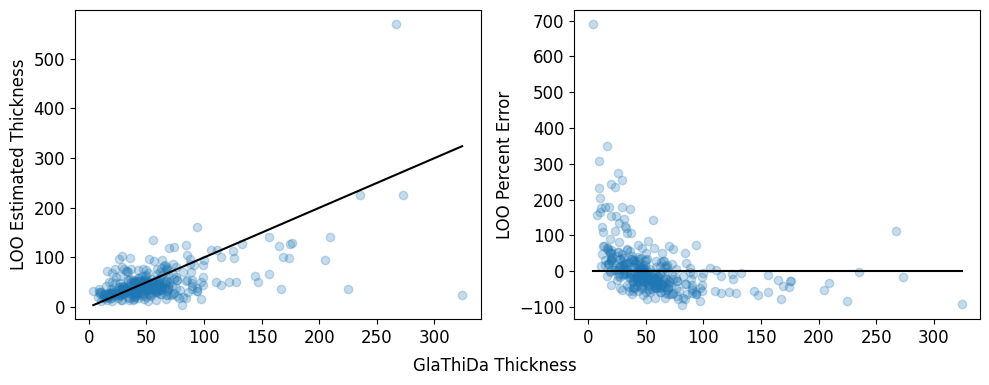

In [11]:
ls = 12
fig, ax = plt.subplots(1,2,figsize = (10,4))
x = fr['Thickness']
y = fr['est']
ax[0].scatter(
    x,y, alpha = 0.25
)
ax[0].plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)
ax[0].set_ylabel('LOO Estimated Thickness',fontsize = ls)

y = fr['Percent Error']
ax[1].scatter(
    x,y, alpha = 0.25
)
ax[1].plot(
    (x.min(),x.max()),
    (0,0),
    '-k'
)
ax[1].set_ylabel('LOO Percent Error',fontsize = ls)
fig.supxlabel('GlaThiDa Thickness', y = 0.05,fontsize = ls)
ax[0].tick_params(axis='both', labelsize=ls)
ax[1].tick_params(axis='both', labelsize=ls)
plt.tight_layout()

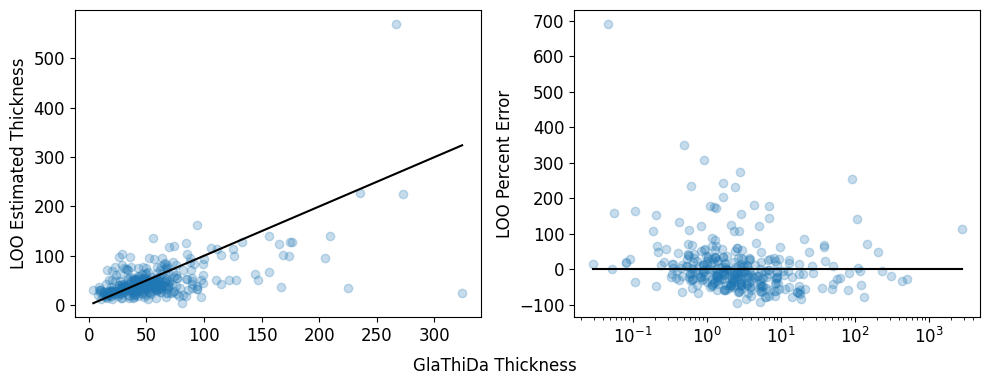

In [12]:
ls = 12
fig, ax = plt.subplots(1,2,figsize = (10,4))
x = fr['Thickness']
y = fr['est']
ax[0].scatter(
    x,y, alpha = 0.25
)
ax[0].plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)
ax[0].set_ylabel('LOO Estimated Thickness',fontsize = ls)

y = fr['Percent Error']
x = fr['Area']
ax[1].scatter(
    x,y, alpha = 0.25
)
ax[1].plot(
    (x.min(),x.max()),
    (0,0),
    '-k'
)
ax[1].set_xscale('log')
ax[1].set_ylabel('LOO Percent Error',fontsize = ls)
fig.supxlabel('GlaThiDa Thickness', y = 0.05,fontsize = ls)
ax[0].tick_params(axis='both', labelsize=ls)
ax[1].tick_params(axis='both', labelsize=ls)
plt.tight_layout()

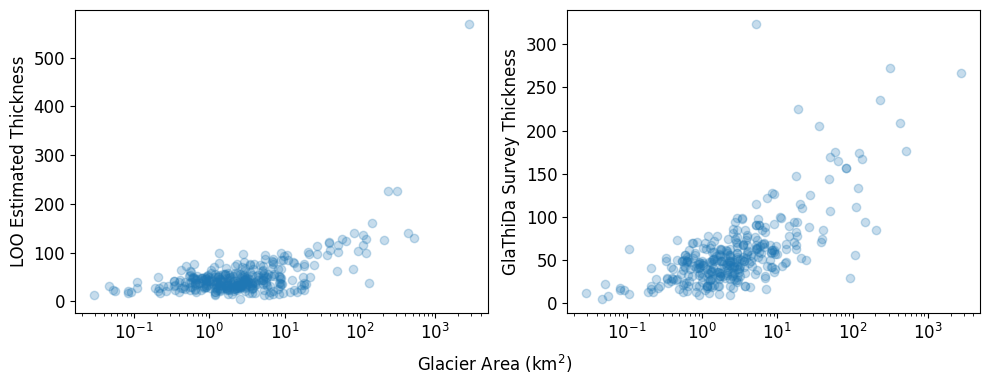

In [13]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
x = fr['Area']
y = fr['est']
ax[0].scatter(
    x,y,alpha = 0.25
)
ax[0].set_xscale('log')

ax[0].set_ylabel('LOO Estimated Thickness', fontsize = ls)

y = fr['Thickness']
ax[1].scatter(
    x,y,alpha = 0.25
)
ax[1].set_xscale('log')
ax[1].set_ylabel('GlaThiDa Survey Thickness',fontsize = ls)
fig.supxlabel('Glacier Area (km$^2$)', y = 0.05,fontsize = ls)
ax[0].tick_params(axis='both', labelsize=ls)
ax[1].tick_params(axis='both', labelsize=ls)
plt.tight_layout()

### Let's see if a linear model does anything different

In [14]:
lin_model = {}
lin_model_history = {}
l1 = 16
l2 = 4
normalizer = {}
loss = 'mae'
model_path = '/data/fast1/glacierml/models/LOO_linear/'
for n in tqdm(df.index):
    isdir = os.path.join(
        model_path ,str(n)
    )
    if os.path.isdir(isdir) == True:
        lin_model[n] = gl.load_dnn_model(isdir)
    elif os.path.isdir(isdir) == False:
        

#         total_inputs = (len(df.columns)) * (len(df) - 1)
#         dp = int(pr * total_inputs)
#         tp = dp - (len(df.columns) + (len(df.columns)-1) )
#         g = (len(df.columns) + (len(df.columns) - 1))
#         l2[n] = 4
#         l1[n] = int((dp - 1 - g - 2*l2[n]) / (10 + l2[n]))
        normalizer = preprocessing.Normalization(axis=-1)
        normalizer.adapt(np.array(trfeat[n]))

        lin_model[n] = gl.build_linear_model(
            normalizer, learning_rate = 0.01, 
            layer_1 = l1, layer_2 = l2
        )

        lin_model_history[n] = model[n].fit(
            trfeat[n],
            trlabs[n],
            validation_split=0.2,
            callbacks = [callback],
            verbose=0, 
            epochs=500
        )
        model_filename = isdir
        lin_model[n].save(model_filename)

100%|██████████| 341/341 [01:04<00:00,  5.32it/s]


In [15]:
# results = {}
# residuals = {}
# final_results = pd.DataFrame()
# # residuals = pd.DataFrame()
# y = {}
# for n in tqdm(df.index):
#     results[n] = model[n].evaluate(tefeat[n], telabs[n],verbose = 0)
#     y[n] = model[n].predict(tefeat[n],verbose = 0).flatten()
# #     residuals[n] = y[n] - telabs[n].values[0]
# #     p_res = residuals[n] / telabs[n].values[0]
#     RMSE = np.sqrt(metrics.mean_squared_error(telabs[n].values, y[n]))
#     MAPerror = np.mean((y[n] - (telabs[n].values[0])) / telabs[n].values[0]) * 100 


# #     tq75 = np.percentile(residuals[n], 75)
# #     tq25 = np.percentile(residuals[n], 25)

# #     TIQR = tq75 - tq25

#     z = model[n].predict(df.drop(['RGIId','Thickness'],axis = 1),verbose = 0).flatten()
#     ver_res = z - df['Thickness']
#     ver_res_mean = np.mean(ver_res)
#     ver_res_std =  np.std(ver_res)
#     vq75 = np.percentile(ver_res,75)
#     vq25 = np.percentile(ver_res,25)
#     VIQR = vq75 - vq25

#     test_res_n = pd.DataFrame(pd.Series(n,name = 'i'))
#     test_res = pd.DataFrame(pd.Series((RMSE), name = 'Test Res'))
# #     test_res_std = pd.DataFrame(pd.Series(np.std(residuals[n].values),name = 'Val STD'))

#     test_res_n['Model Loss'] = results[n]
#     test_res_n['RMSE'] = RMSE
#     test_res_n['Percent Error'] = MAPerror
#     trm = test_res_n.join(test_res)
# #     test_res_mean = test_res_mean.join(test_res_std)
# #     test_res_mean['TRes Max'] = residuals[n].max()
# #     test_res_mean['TRes Min'] = residuals[n].min()
# #     test_res_mean['TRes IQR'] = TIQR
#     trm['VRes Mean'] = ver_res_mean    
#     trm['VRes STD'] = ver_res_std
#     trm['VRes Max'] = ver_res.max()
#     trm['VRes Min'] = ver_res.min()
#     trm['VRes IQR'] = VIQR
#     trm['est'] = y[n]
#     trm['Thickness'] = telabs[n].values[0]
#     trm['Area'] = tefeat[n]['Area'].values[0]
#     trm['Lmax'] = tefeat[n]['Lmax'].values[0]
#     trm['Slope'] = tefeat[n]['Slope'].values[0]
#     trm['Zmin'] = tefeat[n]['Zmin'].values[0]
#     trm['Zmed'] = tefeat[n]['Zmed'].values[0]
#     trm['Zmax'] = tefeat[n]['Zmax'].values[0]
#     trm['CenLat'] = tefeat[n]['CenLat'].values[0]
#     trm['CenLon'] = tefeat[n]['CenLon'].values[0]
#     trm['Aspect'] = tefeat[n]['Aspect'].values[0]
#     final_results = pd.concat([final_results,trm])
# fr_lin = final_results
# fr_lin['unc'] = fr_lin['RMSE'] + fr_lin['Percent Error']
# fr_lin = fr_lin.set_index('i')
# fr_lin.to_pickle(model_path + 'final_results_linear.pkl')

In [16]:
fr_lin = pd.read_pickle(model_path + 'final_results_linear.pkl')

In [17]:
fr_lin.sort_values('Percent Error')

,Model Loss,RMSE,Percent Error,Test Res,VRes Mean,VRes STD,VRes Max,VRes Min,VRes IQR,est,Thickness,Area,Lmax,Slope,Zmin,Zmed,Zmax,CenLat,CenLon,Aspect,unc
i,,,,,,,,,,,,,,,,,,,,,
323,72.463943,72.463943,-426.258469,72.463943,-8.369957,34.522456,101.326004,-353.571629,24.520054,-55.463943,17.0,2.555,1713,32.6,1589,2067,2653,-41.1110,-72.49870,189,-353.794525
327,44.629677,44.629675,-278.935480,44.629675,-8.430789,34.466833,99.243454,-353.855051,24.586143,-28.629675,16.0,6.985,3688,14.4,1783,2167,3059,-38.7112,-71.74050,237,-234.305805
335,63.066643,63.066643,-274.202800,63.066643,-8.868833,35.397610,106.695221,-360.833046,24.634315,-40.066643,23.0,0.585,1747,29.7,3879,4371,4859,-33.1875,-70.26890,177,-211.136157
333,46.156628,46.156628,-230.783129,46.156628,-5.664880,34.497503,107.110535,-350.988098,24.597927,-26.156628,20.0,1.643,2296,29.5,4296,4835,5358,-33.2464,-70.21830,210,-184.626501
320,76.907089,76.907093,-226.197314,76.907093,-9.571450,37.466913,105.000824,-375.380394,24.407246,-42.907093,34.0,2.541,3522,24.2,3394,3922,4657,-34.7806,-70.30800,169,-149.290221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,17.603792,17.603792,220.047402,17.603792,-7.441590,34.037494,105.116867,-349.166624,23.298187,25.603792,8.0,0.056,383,19.3,2695,2761,2820,46.5967,8.61109,65,237.651195
201,25.671658,25.671658,233.378696,25.671658,-8.673462,36.629198,108.321747,-369.544670,23.888031,36.671658,11.0,1.255,1969,18.3,2610,2885,3145,46.9675,11.25370,87,259.050354
226,28.127064,28.127064,281.270647,28.127064,-8.861861,35.553060,103.231247,-363.652664,25.150204,38.127064,10.0,1.677,1899,16.2,2526,2801,3062,46.8529,10.13090,323,309.397711


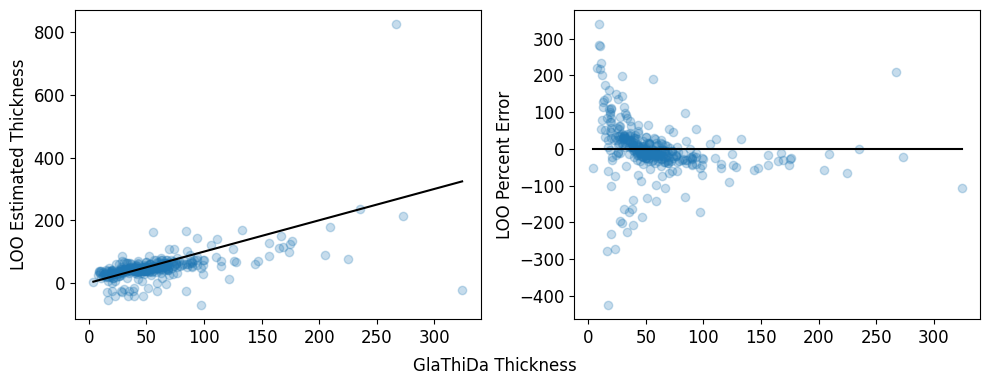

In [18]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
x = fr_lin['Thickness']
y = fr_lin['est']
ax[0].scatter(
    x,y, alpha = 0.25
)
ax[0].plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[0].set_ylabel('LOO Estimated Thickness', fontsize = ls)
fig.supxlabel('GlaThiDa Thickness', y = 0.05, fontsize = ls)

y = fr_lin['Percent Error']
ax[1].scatter(
    x,y, alpha = 0.25
)
ax[1].plot(
    (x.min(),x.max()),
    (0,0),
    '-k'
)
ax[1].set_ylabel('LOO Percent Error', fontsize = ls)
ax[0].tick_params(axis='both', labelsize=ls)
ax[1].tick_params(axis='both', labelsize=ls)
plt.tight_layout()

In [19]:
fr.sort_values('RMSE')

,Model Loss,RMSE,Percent Error,Test Res,VRes Mean,VRes STD,VRes Max,VRes Min,VRes IQR,est,Thickness,Area,Lmax,Slope,Zmin,Zmed,Zmax,CenLat,CenLon,Aspect,unc
i,,,,,,,,,,,,,,,,,,,,,
45,0.181786,0.181786,-0.284040,0.181786,-3.666122,27.421481,103.274719,-276.821934,19.592812,63.818214,64.0,5.205,4365,13.9,72,345,725,78.877900,12.031100,12,-0.102254
285,0.278477,0.278477,0.568320,0.278477,-7.061875,31.458885,83.215424,-306.481068,27.295639,49.278477,49.0,0.992,1412,16.7,3112,3258,3480,44.839293,79.461029,26,0.846797
248,0.310852,0.310852,1.636063,0.310852,-2.188756,26.755843,109.581650,-268.822578,18.233116,19.310852,19.0,0.661,767,19.6,2709,2889,2999,46.166600,6.937150,154,1.946916
279,0.324692,0.324692,-0.690834,0.324692,-2.376545,27.133950,110.396225,-263.207050,19.345596,46.675308,47.0,0.903,1972,16.7,3387,3567,3821,44.701471,79.595718,82,-0.366142
179,0.351231,0.351231,-1.033031,0.351231,-7.576174,34.382947,79.354584,-306.206369,30.926357,33.648769,34.0,3.690,2746,17.7,2597,2973,3266,47.065400,11.663600,0,-0.681801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,109.233109,109.233109,-53.284442,109.233109,-7.045046,34.073963,99.225830,-285.042030,32.657316,95.766891,205.0,36.049,9888,6.6,148,1186,1568,66.657000,13.853000,330,55.948666
50,130.573334,130.573334,-78.187627,130.573334,-29.973804,42.223201,58.192360,-308.074946,39.991230,36.426666,167.0,132.743,22508,7.7,107,515,954,78.748100,13.891100,104,52.385707
86,189.294144,189.294140,-84.130728,189.294140,-25.722953,39.200419,47.928322,-313.923395,37.264759,35.705860,225.0,19.002,6666,8.3,522,1711,1940,61.711000,7.025000,347,105.163412


Text(0.5, -0.05, 'Glacier Area (km$^2$)')

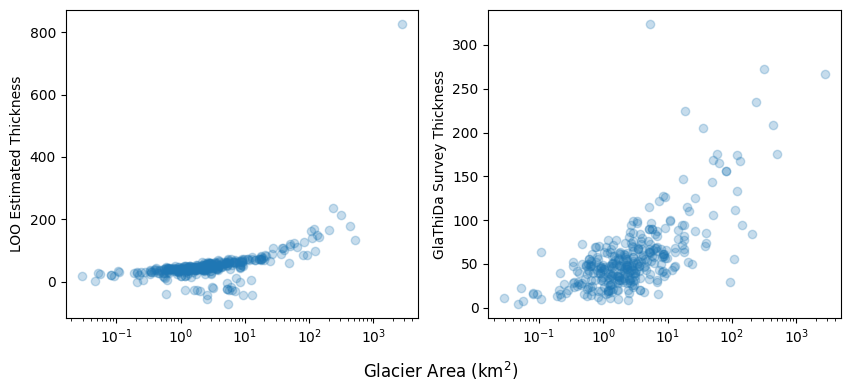

In [20]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
x = fr_lin['Area']
y = fr_lin['est']
ax[0].scatter(
    x,y,alpha = 0.25
)
ax[0].set_xscale('log')
ax[0].set_ylabel('LOO Estimated Thickness')

y = fr_lin['Thickness']
ax[1].scatter(
    x,y,alpha = 0.25
)
ax[1].set_xscale('log')
ax[1].set_ylabel('GlaThiDa Survey Thickness')
fig.supxlabel('Glacier Area (km$^2$)', y = -.05)

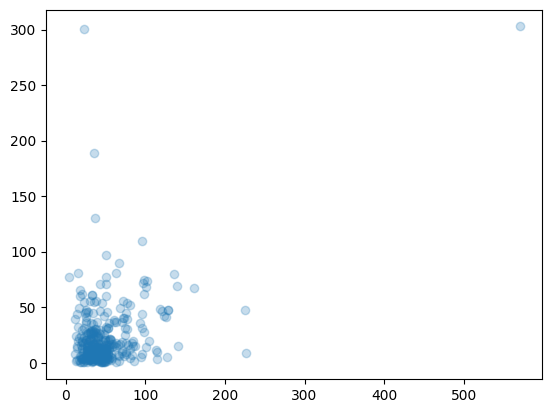

In [21]:
plt.scatter(
    fr['est'],
    fr['RMSE'],
    alpha = 0.25
)

## Are residuals and percent residuals normally distributed with features?

In [23]:
# for feat in ['Area','Lmax','Slope','Zmin']:
#     plt.scatter(
#         fr[feat],
#         fr['RMSE']
#     )
#     if feat == 'Area' or feat == 'Lmax':
#         plt.xscale('log')
#     plt.xlabel(feat)
#     plt.ylabel('LOO RMSE')
#     plt.show()

# for feat in ['Area','Lmax','Slope','Zmin']:
#     plt.scatter(
#         fr[feat],
#         fr['Percent Error']
#     )
#     if feat == 'Area' or feat == 'Lmax':
#         plt.xscale('log')
#     plt.xlabel(feat)
#     plt.ylabel('LOO % error')
#     plt.show()

In [24]:
# plt.scatter(
#     fr['Area'],
#     fr['RMSE']
# )
# plt.yscale('log')
# plt.xscale('log')

### Use each LOO model to predict RGI

In [25]:
RGI = gl.load_RGI()
rfp = RGI[list(df)[:-1]]

# for n in tqdm(model.keys()):
#     preds = pd.Series(model[n].predict(rfp).flatten(), name = n)
#     RGI = pd.concat([RGI,preds], axis = 1)
# RGI.to_pickle('rgi_est_raw.pkl')
RGI = pd.read_pickle('rgi_est_raw.pkl')

In [26]:
cols = []
for i in range(341):
    cols.append(i)

In [27]:
unc_cols = []
for i in range(341):
    unc_cols.append(str(i) + '_')

In [28]:
rgi_list = list(df)[:-1]
rgi_list.append('RGIId')

In [29]:
df = pd.merge(df, RGI, how = 'inner', on = rgi_list)
X = np.mean(df[range(341)], axis = 1)
se = np.std(df[range(341)], axis = 1) / np.sqrt(341)

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

/tmp/ipykernel_2714133/3749496890.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['LCI'] = X - (1.96 * se)
/tmp/ipykernel_2714133/3749496890.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UCI'] = X + (1.96 * se)


Text(0.5, 1.0, 'Leave-One-Out X-val 95% CI')

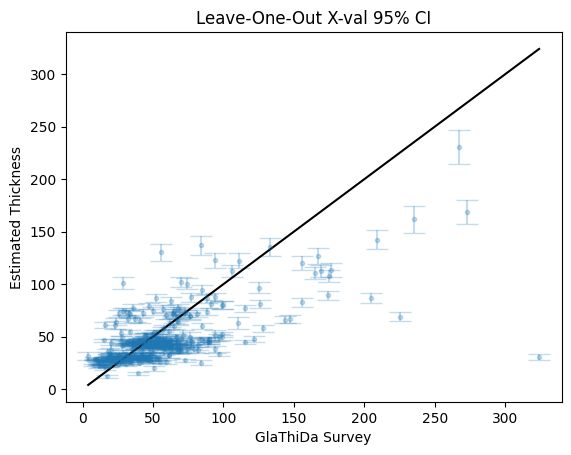

In [30]:
x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = np.mean(df[cols],axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = '.',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')

Text(0.5, -0.05, 'Glacier Area (km$^2$)')

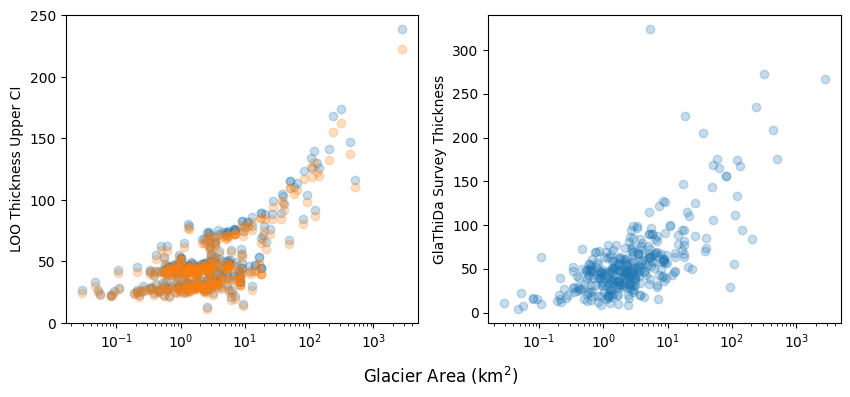

In [31]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
x = df['Area']
y1 = df['UCI']
y2 = df['LCI']
ax[0].scatter(
    x,y1,alpha = 0.25
)
ax[0].scatter(
    x,y2,alpha = 0.25
)
ax[0].set_xscale('log')
ax[0].set_ylabel('LOO Thickness Upper CI')

y = df['Thickness']
ax[1].scatter(
    x,y,alpha = 0.25
)
ax[1].set_xscale('log')
ax[1].set_ylabel('GlaThiDa Survey Thickness')
fig.supxlabel('Glacier Area (km$^2$)', y = -.05)

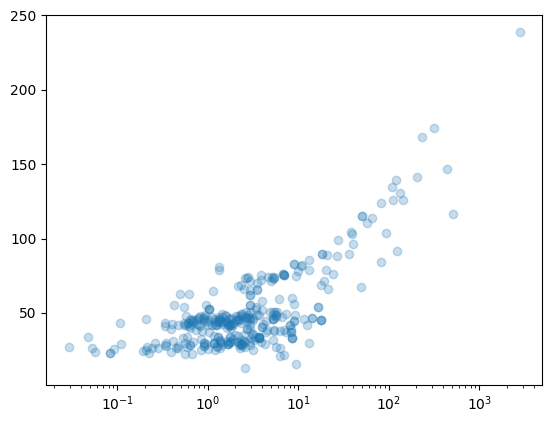

In [32]:
x = df['Area']
y = df['UCI']
plt.scatter(x,y,alpha = 0.25)
plt.xscale('log')

In [33]:
ref_pth = '/data/fast1/glacierml/data/reference_thicknesses/'
ref = pd.DataFrame()
for file in os.listdir(ref_pth):
    if 'Farinotti' in file:
        file_reader = pd.read_csv('reference_thicknesses/' + file)
        ref = pd.concat([ref, file_reader], ignore_index = True) 
ref = ref.rename(columns = {
     'Farinotti Mean Thickness':'FMT',
})
ref = ref[[
     'FMT',
     'RGIId',
]]

In [34]:
df = pd.merge(df, ref, how = 'inner', on = 'RGIId')

In [35]:
df['est'] = df[['UCI','LCI']].mean(axis = 1)

/tmp/ipykernel_2714133/3884684130.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['est'] = df[['UCI','LCI']].mean(axis = 1)


Text(0.5, 0, 'GlaThiDa Survey')

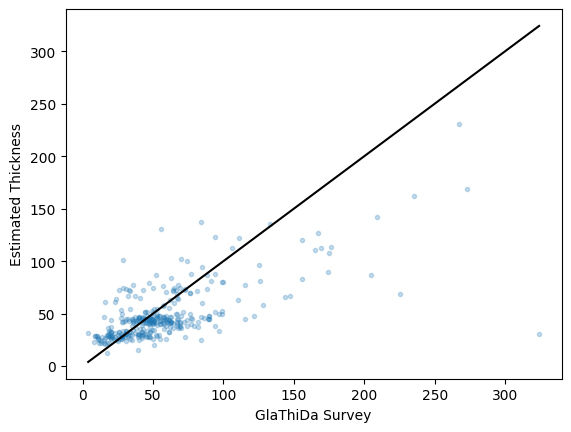

In [36]:
x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = df['est']
plt.scatter(
    x,y,
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    marker = '.',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
# plt.title('Leave-One-Out X-val 95% CI')

In [38]:
obs = df['Thickness']
obs_mean = obs.mean()
obs_std = obs.std()
obs_se = obs_mean / obs_std

pred = df['est']
pred_mean = pred.mean()
pred_std = pred.std()
pred_se = pred_mean / pred_std

pooled_var = (obs_std**2 + pred_std**2) / 2

t = (pred_mean - obs_mean) / 2

print(t)

-4.324167408202051


In [39]:
obs = df['Thickness']
obs_mean = obs.mean()
obs_std = obs.std()
obs_se = obs_mean / obs_std

pred = df['FMT']
pred_mean = pred.mean()
pred_std = pred.std()
pred_se = pred_mean / pred_std

pooled_var = (obs_std**2 + pred_std**2) / 2

t = (pred_mean - obs_mean) / 2

print(t)

1.6803378548387116


In [40]:
df['Residual'] = df['est'] - df['Thickness']
df['FResidual'] = df['FMT'] - df['Thickness']

/tmp/ipykernel_2714133/2258911450.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Residual'] = df['est'] - df['Thickness']
/tmp/ipykernel_2714133/2258911450.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['FResidual'] = df['FMT'] - df['Thickness']


In [41]:
mean_1 = df['Residual'].mean()
std_1 = df['Residual'].std()
se_1 = df['Residual'].std() / np.sqrt(341)

mean_2 = df['FResidual'].mean()
std_2 = df['FResidual'].std()
se_2 = df['FResidual'].std() / np.sqrt(341)

In [ ]:
Z_1 = (mean_1 - 0) / se_1

Z_2 = (mean_2 - 0) / se_2

print(Z_1)
print(Z_2)

In [ ]:
x1 = df['Residual']
x2 = df['FResidual']
kde1 = stats.gaussian_kde(np.array(x1))
kde2 = stats.gaussian_kde(np.array(x2))
#visualize KDE
x1_eval = np.linspace(x1.min(),x1.max(), num=200)
plt.plot(x1_eval, kde1(x1_eval), '-',color = 'blue',label = 'This study Residual')

x2_eval = np.linspace(x2.min(),x2.max(), num=200)
plt.plot(x2_eval, kde2(x2_eval),color = 'orange',label = 'Farinotti Residual')

plt.plot(
    (x1.mean(),x1.mean()),
    (0,0.02),'--',color = 'blue',label = 'This Study Mean Residual'
)

plt.plot(
    (x2.mean(),x2.mean()),
    (0,0.02),'--',color = 'orange',label = 'Farinotti Mean Residual'
)


plt.legend()
print(f'This study mean residual = {x1.mean()}')
print(f'Farinotti mean residual = {x2.mean()}')

In [ ]:
#get probability
p1 = kde1.integrate_box_1d(-np.inf, 0)
p2 = kde2.integrate_box_1d(-np.inf, 0)
print(f'probabiliity of achieving residual of 0 = {p1}')
print(f'probabiliity of achieving Fresidual of 0 = {p2}')


In [ ]:
import scipy.stats as st
print(st.norm.pdf(Z_1))
print(st.norm.pdf(Z_2))

In [ ]:
x1 = np.sort(np.random.standard_normal(size=500))
kde1 = stats.gaussian_kde(np.array(x1))
kde2 = stats.gaussian_kde(np.array(x2_eval))
#visualize KDE
plt.plot(x1, kde1(x1), '-',color = 'blue',label = 'This study Residual')

# x2_eval = np.linspace(x2.min(),x2.max(), num=200)
# plt.plot(x2_eval, kde2(x2_eval),color = 'orange',label = 'Farinotti Residual')

# plt.plot(
#     (x1.mean(),x1.mean()),
#     (0,0.02),'--',color = 'blue',label = 'This Study Mean Residual'
# )

# plt.plot(
#     (x2.mean(),x2.mean()),
#     (0,0.02),'--',color = 'orange',label = 'Farinotti Mean Residual'
# )


plt.legend()
print(f'This study mean residual = {x1.mean()}')
print(f'Farinotti mean residual = {x2.mean()}')

In [ ]:
for i in range(216501):
    glac = RGI.iloc[i]
    print(sum(glac[cols] / fr['unc']) / sum(1/fr['unc']))
    break
#     (RGI[cols] /  fr['unc'].T) / (1/fr['unc'].T)

In [ ]:
for i in range(5):
    plt.hist(data[range(341)].iloc[random.randint(0,341)])
    plt.show()

In [ ]:
df

In [ ]:
print(f'LOO Global Volume Estimate {np.round(sum(lb)), np.round(sum(ub))} * 10^3 km^3')

In [ ]:
dfci = df[['LCI','UCI']]

In [ ]:
x = df['Thickness']
y = np.mean(dfci, axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = 'o',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (y.min(),y.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')

In [ ]:
df

In [ ]:
df['we'].max()